### 此例不使用高斯白雜訊(AWGN)來產生錯誤, 而是產生隨機的算術權種錯誤(AWE)

### Define function
* (Not including 2's complement range)

In [10]:
import math
import numpy as np


def decimal_to_binary(decimal_number):
    if decimal_number == 0:
        return "0"
    # 處理正數：直接轉換
    if decimal_number > 0:
        return bin(decimal_number)[2:]  # 移除 "0b" 前綴
       # 處理負數：自動計算所需位元數（2's complement）
    abs_value = abs(decimal_number)
    bits = abs_value.bit_length() + 1  # 負數多一個符號位元
    two_complement_value = (1 << bits) + decimal_number
    
    return bin(two_complement_value)[2:]  # 移除 "0b" 前綴

def bits_needed(number):
    if number < 0:
        raise ValueError("2's complement is not available")  # 如果輸入負數，拋出錯誤
    if number == 0:
        return 1  # 0 需要 1 個位元
    
    # 計算位元數
    bits = math.floor(math.log2(number)) + 1
    return bits


def bits_range(bits, signed=False):     ## 可選擇設定 有號數 或 無號數
    if bits <= 0:
        return "位元數必須為正整數！"
    
    if signed:
        # 二補數範圍: -2^(bits-1) 到 2^(bits-1)-1
        min_value = -(2**(bits - 1))
        max_value = 2**(bits - 1) - 1
    else:
        # 無符號範圍: 0 到 2^bits - 1
        min_value = 0
        max_value = 2**bits - 1

    return min_value, max_value

## 把重複的 AWE 去除
def remove_duplicates(input_list):
    unique_list = []
    for number in input_list:
        if number not in unique_list:
            unique_list.append(number)
    return sorted(unique_list)


print("一個2補數所需要的位元數",bits_needed(120))
print("一bits數可表示的2補數的範圍",bits_range(bits_needed(120)))
print("一個2補數表達為二進制為:",decimal_to_binary(-8))

一個2補數所需要的位元數 7
一bits數可表示的2補數的範圍 (0, 127)
一個2補數表達為二進制為: 11000


## 以 18-bits 做BLE(AWE)R

### 取A=59做 SEC ANcode

In [11]:
import numpy as np
from numpy.random import rand, randn, randint
import random
import matplotlib.pyplot as plt
from numpy import sqrt

In [12]:
import scipy
print(scipy.__version__)

1.15.2


In [13]:
def A59_AN_decoder(residue,quotient):
    s_re=str(residue)
    msg={
        "1": lambda quotient: quotient,
        "2": lambda quotient: quotient,
        "4": lambda quotient: quotient,
        "8": lambda quotient: quotient,
        "16": lambda quotient: quotient,
        "32": lambda quotient: quotient,
        "5": lambda quotient: quotient-1,
        "10": lambda quotient: quotient-2,
        "20": lambda quotient: quotient-4,
        "40": lambda quotient: quotient-8,
        "21": lambda quotient: quotient-17,
        "42": lambda quotient: quotient-34,
        "25": lambda quotient: quotient-69,
        "50": lambda quotient: quotient-138,
        "41": lambda quotient: quotient-277,
        "23": lambda quotient: quotient-555,
        "46": lambda quotient: quotient-1110,
        "33": lambda quotient: quotient-2221,
        "7": lambda quotient: quotient-4443,
        "14": lambda quotient: quotient-8886,
        "28": lambda quotient: quotient-17772,
        "56": lambda quotient: quotient-35544,
        "53": lambda quotient: quotient-71089,
        "47": lambda quotient: quotient-142179,
        "35": lambda quotient: quotient-284359,
        "11": lambda quotient: quotient-568719,
        "22": lambda quotient: quotient-1137438,
        "44": lambda quotient: quotient-2274876,
        "29": lambda quotient: quotient-4549753,
        "58": lambda quotient: quotient+1,
        "57": lambda quotient: quotient+1,
        "55": lambda quotient: quotient+1,
        "51": lambda quotient: quotient+1,
        "43": lambda quotient: quotient+1,
        "27": lambda quotient: quotient+1,
        "54": lambda quotient: quotient+2,
        "49": lambda quotient: quotient+3,
        "39": lambda quotient: quotient+5,
        "19": lambda quotient: quotient+9,
        "38": lambda quotient: quotient+18,
        "17": lambda quotient: quotient+35,
        "34": lambda quotient: quotient+70,
        "9": lambda quotient: quotient+139,
        "18": lambda quotient: quotient+278,
        "36": lambda quotient: quotient+556,
        "13": lambda quotient: quotient+1111,
        "26": lambda quotient: quotient+2222,
        "52": lambda quotient: quotient+4444,
        "45": lambda quotient: quotient+8887,
        "31": lambda quotient: quotient+17773,
        "3": lambda quotient: quotient+35545,
        "6": lambda quotient: quotient+71090,
        "12": lambda quotient: quotient+142180,
        "24": lambda quotient: quotient+284360,
        "48": lambda quotient: quotient+568720,
        "37": lambda quotient: quotient+1137439,
        "15": lambda quotient: quotient+2274877,
        "30": lambda quotient: quotient+4549754,
        "0" :lambda quotient: quotient,
    }[s_re](quotient)
    msg
    return int(msg)


def Barret_q_59(x):
    x = np.int64(x)
    q = (x * 284359) >> 24       ## (2^24)//59後, 右移24次         
    r = x - q * 59
    if r < 59:
        return (r,q)
    else:
        return (r - 59, q + 1)
    

### 取A=6311做 DEC ANcode

In [14]:
def create_mapping(source_list, address_map):
    """
    建立值到位址和位址到值的雙向映射。
    若 address_map 中某位址沒有對應值，則該位址的值為 0。
    
    參數:
    source_list (list): 原始資料列表。
    address_map (list): 位址映射列表。
    
    回傳:
    tuple: (值到位址的映射, 位址到值的映射)
    """
    # 初始化值到位址的映射
    value_to_address = {value: addr for value, addr in zip(source_list, address_map)}
    
    # 初始化位址到值的映射，未指定的位址預設為 0
    max_address = max(address_map)  # 確保涵蓋所有位址
    address_to_value = {addr: 0 for addr in range(max_address + 1)}  # 預設為 0
    for value, addr in zip(source_list, address_map):
        address_to_value[addr] = value  # 更新有指定值的位址

    return value_to_address, address_to_value

# 測試數據
source_list = [10, 20, 30]
address_map = [2, 0, 4]

# 建立映射
value_to_address, address_to_value = create_mapping(source_list, address_map)

# 顯示結果
print("值到位址的映射:", value_to_address)
print("位址到值的映射:", address_to_value)


# 測試數據
source_list = [10, 20, 30, 40]
address_map = [2, 0, 3, 1]

# 建立映射
value_to_address, address_to_value = create_mapping(source_list, address_map)

# 測試查詢
print("值到位址:", value_to_address)  # 查詢 10 -> 2, 20 -> 0
print("位址到值:", address_to_value)  # 查詢 2 -> 10, 0 -> 20

# 範例查詢
value = 10
address = 2
print(f"輸入值 {value}, 對應位址: {value_to_address[value]}")
print(f"輸入位址 {address}, 對應值: {address_to_value[address]}")

值到位址的映射: {10: 2, 20: 0, 30: 4}
位址到值的映射: {0: 20, 1: 0, 2: 10, 3: 0, 4: 30}
值到位址: {10: 2, 20: 0, 30: 3, 40: 1}
位址到值: {0: 20, 1: 40, 2: 10, 3: 30}
輸入值 10, 對應位址: 2
輸入位址 2, 對應值: 10


In [15]:
### 輸入數值為data, ANcode的A為AN
### 乘完A後的數值為 input
data = 262113           ## (0~262143)
AN = 6311
input = data*AN
bits = bits_needed(input)
print("AN資料的位元數:", bits)

AN資料的位元數: 31


In [16]:
### 1-bit AWE:
AWE_1=[]
e1=0     ## 錯誤數量
e1_data=[]
for i in range(0, bits):
    e1_data.insert(e1 , input + 2**i)
    AWE_1.insert(e1, 2**i)
    e1 = e1 + 1
    e1_data.insert(e1 , input - 2**i)
    AWE_1.insert(e1, -2**i)
    e1 = e1 + 1
    
### 2-bit AWE:
AWE_2=[]
e2=0     ## 錯誤數量
p=0      ## 錯誤位置
e2_data=[]
for i in range(0, bits):
    for j in range(i+1, bits):
        e2_data.insert(e2 , (input + 2**i + 2**j))
        AWE_2.insert(e2 , (2**i + 2**j))        
        print(f"第 {e2} 筆錯誤資料: {e2_data[e2]}")
        print(f"第 {e2} 筆算術錯誤: {AWE_2[e2]}")
        e2 = e2 + 1
        e2_data.insert(e2 , (input + 2**i - 2**j))
        AWE_2.insert(e2 , (2**i - 2**j))        
        print(f"第 {e2} 筆錯誤資料: {e2_data[e2]}")
        print(f"第 {e2} 筆算術錯誤: {AWE_2[e2]}")
        e2 = e2 + 1
        e2_data.insert(e2 , (input - 2**i + 2**j))
        AWE_2.insert(e2 , (-2**i + 2**j))                
        print(f"第 {e2} 筆錯誤資料: {e2_data[e2]}")
        print(f"第 {e2} 筆算術錯誤: {AWE_2[e2]}")
        e2 = e2 + 1
        e2_data.insert(e2 , (input - 2**i -2**j))
        AWE_2.insert(e2 , (-2**i - 2**j))
        print(f"第 {e2} 筆錯誤資料: {e2_data[e2]}")
        print(f"第 {e2} 筆算術錯誤: {AWE_2[e2]}")
        e2 = e2 + 1
        p = p + 1
        
## 把list:AWE_1 和 list:AWE_2合併
AWE = AWE_1 + AWE_2
e_total = e1_data + e2_data
print(np.size(e_total))
## 把重複的 AWE 去除
new_AWE = remove_duplicates(AWE)
new_e_total = remove_duplicates(e_total)
AWE_count = np.size(new_AWE)
e_count = np.size(new_e_total)
print(e_count)

第 0 筆錯誤資料: 1654195146
第 0 筆算術錯誤: 3
第 1 筆錯誤資料: 1654195142
第 1 筆算術錯誤: -1
第 2 筆錯誤資料: 1654195144
第 2 筆算術錯誤: 1
第 3 筆錯誤資料: 1654195140
第 3 筆算術錯誤: -3
第 4 筆錯誤資料: 1654195148
第 4 筆算術錯誤: 5
第 5 筆錯誤資料: 1654195140
第 5 筆算術錯誤: -3
第 6 筆錯誤資料: 1654195146
第 6 筆算術錯誤: 3
第 7 筆錯誤資料: 1654195138
第 7 筆算術錯誤: -5
第 8 筆錯誤資料: 1654195152
第 8 筆算術錯誤: 9
第 9 筆錯誤資料: 1654195136
第 9 筆算術錯誤: -7
第 10 筆錯誤資料: 1654195150
第 10 筆算術錯誤: 7
第 11 筆錯誤資料: 1654195134
第 11 筆算術錯誤: -9
第 12 筆錯誤資料: 1654195160
第 12 筆算術錯誤: 17
第 13 筆錯誤資料: 1654195128
第 13 筆算術錯誤: -15
第 14 筆錯誤資料: 1654195158
第 14 筆算術錯誤: 15
第 15 筆錯誤資料: 1654195126
第 15 筆算術錯誤: -17
第 16 筆錯誤資料: 1654195176
第 16 筆算術錯誤: 33
第 17 筆錯誤資料: 1654195112
第 17 筆算術錯誤: -31
第 18 筆錯誤資料: 1654195174
第 18 筆算術錯誤: 31
第 19 筆錯誤資料: 1654195110
第 19 筆算術錯誤: -33
第 20 筆錯誤資料: 1654195208
第 20 筆算術錯誤: 65
第 21 筆錯誤資料: 1654195080
第 21 筆算術錯誤: -63
第 22 筆錯誤資料: 1654195206
第 22 筆算術錯誤: 63
第 23 筆錯誤資料: 1654195078
第 23 筆算術錯誤: -65
第 24 筆錯誤資料: 1654195272
第 24 筆算術錯誤: 129
第 25 筆錯誤資料: 1654195016
第 25 筆算術錯誤: -127
第 26 筆錯誤資料: 1654195270
第 26 筆

In [17]:
remainder = []
for m in range(0,AWE_count):
    mod = new_e_total[m] % AN
    remainder.append(mod)

print("錯誤資料對AN取完模數:\n",remainder)

##############################################################
### Barret reduction ###
def Barret_q_6311(x):
    x = np.int64(x)      
    q = (x * 340276 ) >> 31        ## (2^31)//6311後, 右移31次 
    r = x - q * 6311
    if r < 6311:
        return (r,q)
    else:
        return (r - 6311,q+1)
    
Barret_remainder = []
for m in range(0,AWE_count):
    Barret_r,Barret_q = Barret_q_6311(new_e_total[m])
    Barret_remainder.append(Barret_r)

def unique(input_list):
    # 使用集合判斷元素是否有重複
    return len(input_list) == len(set(input_list))
    
print("Barret reduction對錯誤資料取完模數:\n",Barret_remainder)
print("Barret reduction是否可以使用:", Barret_remainder == remainder)
#################################################################
print("所有餘數是否完全相異:", unique(remainder))
print("所有的AWE:\n", new_e_total)
print("原始算術錯誤資料:\n",new_AWE)
print(np.size(remainder))

錯誤資料對AN取完模數:
 [4952, 2023, 3714, 1404, 249, 2827, 4116, 1605, 3505, 4455, 4930, 2012, 553, 2979, 4192, 1643, 3524, 1309, 3357, 4381, 4893, 5149, 5277, 5341, 5373, 5389, 5397, 5401, 5403, 5404, 5405, 5406, 5407, 5409, 5413, 5421, 5437, 5469, 5533, 5661, 5917, 118, 1142, 3190, 975, 2856, 307, 1520, 3946, 2487, 5880, 44, 994, 2894, 383, 1672, 4250, 3095, 785, 2476, 4167, 1857, 702, 3280, 4569, 2058, 3958, 4908, 5383, 2465, 1006, 3432, 4645, 2096, 3977, 1762, 3810, 4834, 5346, 5602, 5730, 5794, 5826, 5842, 5850, 5854, 5856, 5857, 5858, 5859, 5860, 5862, 5866, 5874, 5890, 5922, 5986, 6114, 59, 571, 1595, 3643, 1428, 3309, 760, 1973, 4399, 2940, 22, 497, 1447, 3347, 836, 2125, 4703, 3548, 1238, 5239, 4084, 351, 1640, 5440, 1029, 1979, 2454, 5847, 4388, 503, 1716, 5478, 1048, 5144, 881, 1905, 2417, 2673, 2801, 2865, 2897, 2913, 2921, 2925, 2927, 2928, 2929, 2930, 2931, 2933, 2937, 2945, 2961, 2993, 3057, 3185, 3441, 3953, 4977, 714, 4810, 380, 4142, 5355, 1470, 11, 3404, 3879, 4829, 418, 4218

In [18]:
### 建立錯誤映射表(LUT)
## Decoder
AWE_to_remainder, remainder_to_AWE = create_mapping(new_AWE, Barret_remainder)

## example
example_r1 = Barret_remainder[0]
example_r2 = Barret_remainder[1]
print(f"輸入餘數 {example_r1}, 對應算術錯誤: {remainder_to_AWE[example_r1]}")
print(f"輸入餘數 {example_r2}, 對應算術錯誤: {remainder_to_AWE[example_r2]}")

Raw_data1 = new_e_total[0]-remainder_to_AWE[example_r1]
Raw_data2 = new_e_total[1]-remainder_to_AWE[example_r2]
print(Raw_data1)
print(Raw_data2)
print("更正是否正確:", input == Raw_data1)

輸入餘數 4952, 對應算術錯誤: -1610612736
輸入餘數 2023, 對應算術錯誤: -1342177280
1654195143
1654195143
更正是否正確: True


## 模擬BLAWER
### 橫軸由原先的訊雜比改為:
### AWE的發生機率 (p) * AWE的平均數量（k）

In [19]:
weight_set = [2**i for i in range(0, bits)] + [-2**i for i in range(0, bits)]
print(weight_set)

p_values = np.linspace(1.0, 0, 20)
print(p_values)
k_values = np.linspace(bits, 1, bits)
print(k_values)
print(20+(32 != 20))
print(len(weight_set))

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728, 268435456, 536870912, 1073741824, -1, -2, -4, -8, -16, -32, -64, -128, -256, -512, -1024, -2048, -4096, -8192, -16384, -32768, -65536, -131072, -262144, -524288, -1048576, -2097152, -4194304, -8388608, -16777216, -33554432, -67108864, -134217728, -268435456, -536870912, -1073741824]
[1.         0.94736842 0.89473684 0.84210526 0.78947368 0.73684211
 0.68421053 0.63157895 0.57894737 0.52631579 0.47368421 0.42105263
 0.36842105 0.31578947 0.26315789 0.21052632 0.15789474 0.10526316
 0.05263158 0.        ]
[31. 30. 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14.
 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.]
21
62


p=1.00, BLAWER=0.9993, SEC_BLAWER=0.9545, DEC_BLAWER=0.8987,
p=0.96, BLAWER=0.9580, SEC_BLAWER=0.9152, DEC_BLAWER=0.8609,
p=0.92, BLAWER=0.9159, SEC_BLAWER=0.8749, DEC_BLAWER=0.8227,
p=0.88, BLAWER=0.8745, SEC_BLAWER=0.8355, DEC_BLAWER=0.7821,
p=0.83, BLAWER=0.8323, SEC_BLAWER=0.7939, DEC_BLAWER=0.7120,
p=0.79, BLAWER=0.7903, SEC_BLAWER=0.7541, DEC_BLAWER=0.6765,
p=0.75, BLAWER=0.7494, SEC_BLAWER=0.7149, DEC_BLAWER=0.6379,
p=0.71, BLAWER=0.7077, SEC_BLAWER=0.6476, DEC_BLAWER=0.6020,
p=0.67, BLAWER=0.6661, SEC_BLAWER=0.6076, DEC_BLAWER=0.5642,
p=0.62, BLAWER=0.6240, SEC_BLAWER=0.5699, DEC_BLAWER=0.5041,
p=0.58, BLAWER=0.5835, SEC_BLAWER=0.5323, DEC_BLAWER=0.4698,
p=0.54, BLAWER=0.5406, SEC_BLAWER=0.4924, DEC_BLAWER=0.4322,
p=0.50, BLAWER=0.4764, SEC_BLAWER=0.4528, DEC_BLAWER=0.3776,
p=0.46, BLAWER=0.4374, SEC_BLAWER=0.3965, DEC_BLAWER=0.3452,
p=0.42, BLAWER=0.3975, SEC_BLAWER=0.3594, DEC_BLAWER=0.3102,
p=0.38, BLAWER=0.3581, SEC_BLAWER=0.3238, DEC_BLAWER=0.2619,
p=0.33, BLAWER=0.3188, S

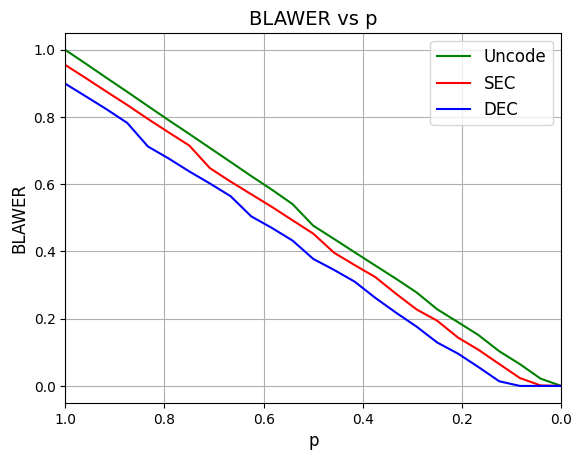

In [61]:
sec_A = 59
dec_A = 6311
min_p = 0.0
Max_p = 1.0
environment = 24
def simulate_BLAWER(n, p, num_trials, weight_set):
    total_errors = 0
    total_sec_errors = 0
    total_dec_errors = 0
    for _ in range(num_trials):
        data = random.randint(0,262143)     # 隨機選擇0~262143的數值
        sec_data = data * sec_A
        dec_data = data * dec_A
        raw_data = data
        # 生成隨機k個AWE
        num_selected = np.random.randint(1,environment)
        selected_values = np.random.choice(weight_set, size= round(num_selected * p), replace=False)
        sum_values = sum(selected_values)
        if random.random() < p:  # 以機率p發生AWE1
            data += sum_values
            sec_data = np.int64(sum_values) + np.int64(sec_data)
            dec_data = np.int64(sum_values) + np.int64(dec_data)
        
        ### SEC:
        SEC_q = sec_data // sec_A
        SEC_r = sec_data % sec_A
        SEC_value = A59_AN_decoder(SEC_r,SEC_q)
        
        ### DEC:
        DEC_r = dec_data % dec_A
        ### using LUT to recover it 
        corrected_DEC_DATA = np.int64(dec_data) - np.int64(remainder_to_AWE[DEC_r])
        ### mod 6311 to get correct data
        DEC_corrected_q = corrected_DEC_DATA // dec_A
                
        # 判斷是否有錯誤
        sec_errors = (SEC_value) != (raw_data)
        total_sec_errors += sec_errors
        
        dec_errors = (DEC_corrected_q) != (raw_data)
        total_dec_errors += dec_errors
        
        errors = (data) != (raw_data)
        total_errors += errors
    # 計算BLAWER
    SEC_BLAWER = total_sec_errors / (num_trials)
    DEC_BLAWER = total_dec_errors / (num_trials)
    BLAWER = total_errors / (num_trials)
    return BLAWER, SEC_BLAWER, DEC_BLAWER

bits = 31             ## 資料位元數
num_trials = 1000000   ## 模擬次數
weight_set = [2**i for i in range(0, bits)] + [-2**i for i in range(0, bits)]
p_values = np.linspace(Max_p, min_p, 25)    
blawer_values = []
sec_blawer_values = []
dec_blawer_values = []

# 執行模擬
for p in p_values:
    blawer , sec_blawer , dec_blawer= simulate_BLAWER(bits, p, num_trials, weight_set)
    blawer_values.append(blawer)
    sec_blawer_values.append(sec_blawer)
    dec_blawer_values.append(dec_blawer)
    print(f"p={p:.2f}, BLAWER={blawer:.4f}, SEC_BLAWER={sec_blawer:.4f}, DEC_BLAWER={dec_blawer:.4f},")


# 繪製結果
Uncode = plt.plot(p_values, blawer_values, 'g',label="Uncode")
SEC    = plt.plot(p_values, sec_blawer_values, 'r',label="SEC")
DEC    = plt.plot(p_values, dec_blawer_values, 'b',label="DEC")

plt.xlim(Max_p, min_p)  # 讓 X 軸從 1.0 到 0.0

# 增加標籤與圖例
plt.legend(fontsize=12, loc="upper right")
plt.xlabel('p', fontsize=12)
plt.ylabel('BLAWER', fontsize=12)
plt.title('BLAWER vs p', fontsize=14)
plt.grid(True)
plt.savefig("BLAWER_vs_P")
plt.show()

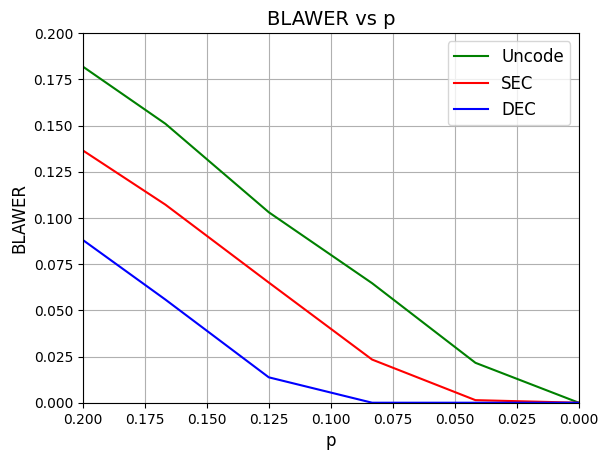

In [62]:
# 繪製結果
Uncode = plt.plot(p_values, blawer_values, 'g',label="Uncode")
SEC    = plt.plot(p_values, sec_blawer_values, 'r',label="SEC")
DEC    = plt.plot(p_values, dec_blawer_values, 'b',label="DEC")

plt.xlim(0.2, 0.0)  # 讓 X 軸從 0.2 到 0.0
plt.ylim(0.0, 0.2)  # 讓 Y 軸從 0.2 到 0.0

# 增加標籤與圖例
plt.legend(fontsize=12, loc="upper right")
plt.xlabel('p', fontsize=12)
plt.ylabel('BLAWER', fontsize=12)
plt.title('BLAWER vs p', fontsize=14)
plt.grid(True)
plt.savefig("BLAWER_vs_P(scaling)")
plt.show()

### 蒙地卡羅模擬(Monte Carlo Simulation) CMOS 製程變異標準差

In [63]:
import scipy
from scipy.stats import truncnorm

a, b = 0, 1  # 範圍限制在 0 ~ 1
mean = 0.5   # 平均值
std = 0.3    # 標准差
data = truncnorm.rvs((a - mean) / std, (b - mean) / std, loc=mean, scale=std, size=1).item()
print(data) 

0.3833409555944835


#### 標準差在 (1.0 ~ 0.0) 之間
##### 不一定符合實際情況,礙於模擬時間過久先做估略模擬

std=1.000, BLAWER=0.462971, SEC_BLAWER=0.431403, DEC_BLAWER=0.393943,
std=0.966, BLAWER=0.460809, SEC_BLAWER=0.429339, DEC_BLAWER=0.391905,
std=0.931, BLAWER=0.456761, SEC_BLAWER=0.425492, DEC_BLAWER=0.388821,
std=0.897, BLAWER=0.454731, SEC_BLAWER=0.423863, DEC_BLAWER=0.386938,
std=0.862, BLAWER=0.450603, SEC_BLAWER=0.419615, DEC_BLAWER=0.383134,
std=0.828, BLAWER=0.446080, SEC_BLAWER=0.415389, DEC_BLAWER=0.379183,
std=0.793, BLAWER=0.441985, SEC_BLAWER=0.411723, DEC_BLAWER=0.375365,
std=0.759, BLAWER=0.437361, SEC_BLAWER=0.407414, DEC_BLAWER=0.371506,
std=0.724, BLAWER=0.431820, SEC_BLAWER=0.402297, DEC_BLAWER=0.366860,
std=0.690, BLAWER=0.424848, SEC_BLAWER=0.395310, DEC_BLAWER=0.360408,
std=0.655, BLAWER=0.418724, SEC_BLAWER=0.389556, DEC_BLAWER=0.354890,
std=0.621, BLAWER=0.408083, SEC_BLAWER=0.379303, DEC_BLAWER=0.345553,
std=0.586, BLAWER=0.397393, SEC_BLAWER=0.369319, DEC_BLAWER=0.336482,
std=0.552, BLAWER=0.386485, SEC_BLAWER=0.359012, DEC_BLAWER=0.326857,
std=0.517, BLAWER=0.

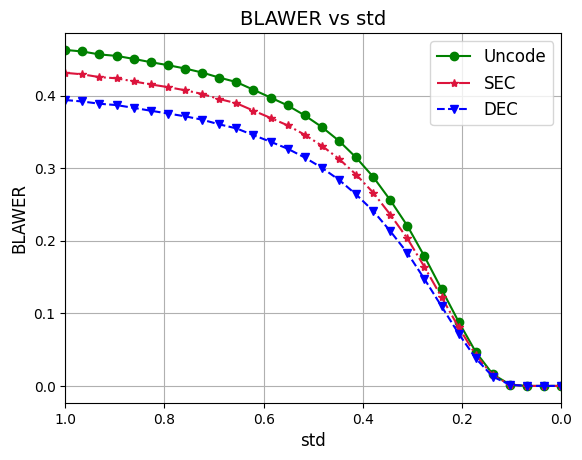

In [ ]:
## 機率改為標準差
sec_A = 59
dec_A = 6311
MAX = 1.0
min = 0.0
min_std = 0.0
Max_std = 1.0
env = 24
mean = 0.2            ### 平均值

bits = 31             ## 資料位元數
num_trials = 1000000   ## 模擬次數
weight_set = [2**i for i in range(0, bits)] + [-2**i for i in range(0, bits)]
std_values = np.linspace(Max_std, min_std, 30)    
blawer_values = []
sec_blawer_values = []
dec_blawer_values = []

def simulate_BLAWER(env, process_std , num_trials, weight_set):
    p = 0               ## 發生錯誤機率
    total_errors = 0
    total_sec_errors = 0
    total_dec_errors = 0
    for _ in range(num_trials):
        data = random.randint(0,262143)     # 隨機選擇0~262143的數值
        p = truncnorm.rvs((min - mean) / process_std, (MAX - mean) / process_std, loc=mean, scale=process_std, size=1).item()
        sec_data = data * sec_A
        dec_data = data * dec_A
        raw_data = data
        # 生成隨機k個AWE
        num_selected = np.random.randint(1,env)
        selected_values = np.random.choice(weight_set,size = round(num_selected * p), replace=False)
        sum_values = sum(selected_values)
        if p > 0.5:                    # 以機率p發生AWE
            data += sum_values
            sec_data += int(sum_values)
            dec_data += int(sum_values) 
        
        ### SEC:
        SEC_q = sec_data // sec_A
        SEC_r = sec_data % sec_A
        SEC_value = A59_AN_decoder(SEC_r,SEC_q)
        
        ### DEC:
        DEC_r = dec_data % dec_A
        ### using LUT to recover it 
        corrected_DEC_DATA = int(dec_data) - int(remainder_to_AWE[DEC_r])
        ### mod 6311 to get correct data
        DEC_corrected_q = corrected_DEC_DATA // dec_A
                
        # 判斷是否有錯誤
        sec_errors = (SEC_value) != (raw_data)
        total_sec_errors += sec_errors
        
        dec_errors = (DEC_corrected_q) != (raw_data)
        total_dec_errors += dec_errors
        
        errors = (data) != (raw_data)
        total_errors += errors
    # 計算BLAWER
    SEC_BLAWER = total_sec_errors / (num_trials)
    DEC_BLAWER = total_dec_errors / (num_trials)
    BLAWER = total_errors / (num_trials)
    return BLAWER, SEC_BLAWER, DEC_BLAWER

# 執行模擬
for s in std_values:
    blawer , sec_blawer , dec_blawer= simulate_BLAWER(env, s, num_trials, weight_set)
    blawer_values.append(blawer)
    sec_blawer_values.append(sec_blawer)
    dec_blawer_values.append(dec_blawer)
    print(f"std={s:.3f}, BLAWER={blawer:.6f}, SEC_BLAWER={sec_blawer:.6f}, DEC_BLAWER={dec_blawer:.6f},")


# 繪製結果
Uncode = plt.plot(std_values, blawer_values, marker='o', linestyle='-',color='#008000',label="Uncode")
SEC    = plt.plot(std_values, sec_blawer_values, marker='*', linestyle='-.',color='#DC143C',label="SEC")
DEC    = plt.plot(std_values, dec_blawer_values, marker='v', linestyle='--',color='#0000FF',label="DEC")

plt.xlim(Max_std, min_std)  # 讓 X 軸從 1.0 到 1e-15

# 增加標籤與圖例
plt.legend(fontsize=12, loc="upper right")
plt.xlabel('std', fontsize=12)
plt.ylabel('BLAWER', fontsize=12)
plt.title('BLAWER vs std', fontsize=14)
plt.grid(True)
plt.savefig("BLAWER_vs_std")
plt.show()

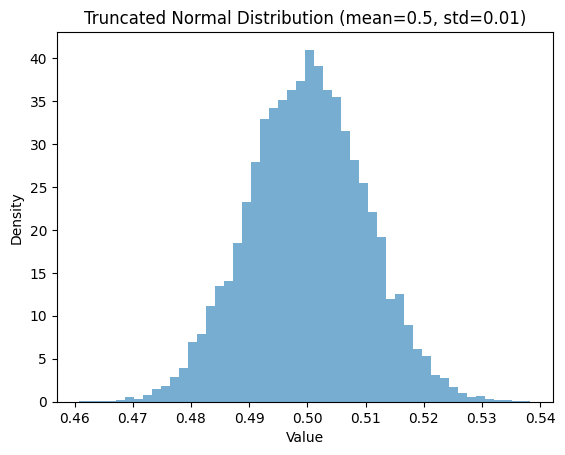

實際標準差: 0.010073986998277381


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

a, b = 0, 1
mean = 0.5
std = 0.01   # 標準差

### 生成截斷常態分布
data = truncnorm.rvs((a - mean)/std, (b - mean)/std, loc=mean, scale=std, size=10000)

### 輸出直方圖
plt.hist(data, bins=50, density=True, alpha=0.6)
plt.title(f"Truncated Normal Distribution (mean={mean}, std={std})")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

### 計算實際標準差
print("實際標準差:", np.std(data))  

#### 標準差在 (0.1 ~ 0.01) 之間
##### 較符合實際情況,但須長時間模擬

std=0.300, BLAWER=0.094716, SEC_BLAWER=0.086734, DEC_BLAWER=0.077680,
std=0.285, BLAWER=0.078556, SEC_BLAWER=0.071954, DEC_BLAWER=0.064244,
std=0.269, BLAWER=0.063202, SEC_BLAWER=0.057814, DEC_BLAWER=0.051542,
std=0.254, BLAWER=0.049234, SEC_BLAWER=0.045000, DEC_BLAWER=0.040200,
std=0.239, BLAWER=0.035888, SEC_BLAWER=0.032662, DEC_BLAWER=0.028942,
std=0.224, BLAWER=0.025208, SEC_BLAWER=0.023102, DEC_BLAWER=0.020406,
std=0.208, BLAWER=0.016252, SEC_BLAWER=0.014926, DEC_BLAWER=0.013240,
std=0.193, BLAWER=0.009960, SEC_BLAWER=0.009078, DEC_BLAWER=0.008002,
std=0.178, BLAWER=0.004896, SEC_BLAWER=0.004554, DEC_BLAWER=0.004008,
std=0.163, BLAWER=0.002152, SEC_BLAWER=0.001970, DEC_BLAWER=0.001724,
std=0.147, BLAWER=0.000652, SEC_BLAWER=0.000588, DEC_BLAWER=0.000520,
std=0.132, BLAWER=0.000140, SEC_BLAWER=0.000120, DEC_BLAWER=0.000104,
std=0.117, BLAWER=0.000012, SEC_BLAWER=0.000010, DEC_BLAWER=0.000010,
std=0.102, BLAWER=0.000000, SEC_BLAWER=0.000000, DEC_BLAWER=0.000000,
std=0.086, BLAWER=0.

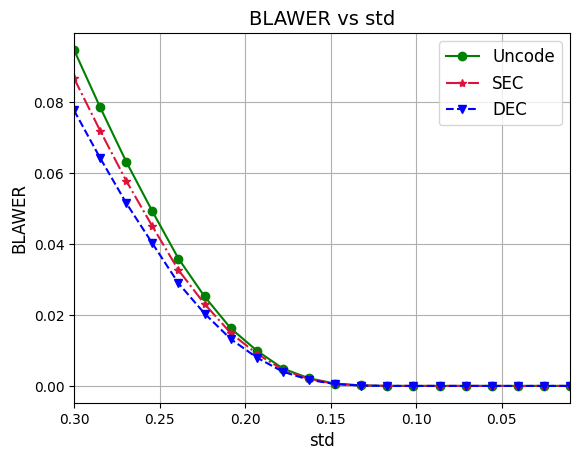

In [ ]:
### 機率改為標準差
### Std Range: (0.01 ~ 0.1)     (0.05 ~ 0.1)    (0.025 ~ 0.06)     
sec_A = 59
dec_A = 6311
MAX = 1.0
min = 0.0
min_std = 0.01
Max_std = 0.3
env = 24
mean = 0                ### 平均值

bits = 31               ## 資料位元數
num_trials = 500000    ## 模擬次數
weight_set = [2**i for i in range(0, bits)] + [-2**i for i in range(0, bits)]
std_values = np.linspace(Max_std, min_std, 20)    
blawer_values = []
sec_blawer_values = []
dec_blawer_values = []

def simulate_BLAWER(env, process_std , num_trials, weight_set):
    p = 0               ## 發生錯誤機率
    total_errors = 0
    total_sec_errors = 0
    total_dec_errors = 0
    for _ in range(num_trials):
        data = random.randint(0,262143)     # 隨機選擇0~262143的數值
        p = truncnorm.rvs((min - mean) / process_std, (MAX - mean) / process_std, loc=mean, scale=process_std, size=1).item()
        sec_data = data * sec_A
        dec_data = data * dec_A
        raw_data = data
        # 生成隨機k個AWE
        num_selected = np.random.randint(1,env)
        selected_values = np.random.choice(weight_set,size = round(num_selected * p), replace=False)
        sum_values = sum(selected_values)
        if p > 0.5:                    # 以機率p發生AWE
            data += sum_values
            sec_data += int(sum_values)
            dec_data += int(sum_values) 
        
        ### SEC:
        SEC_q = sec_data // sec_A
        SEC_r = sec_data % sec_A
        SEC_value = A59_AN_decoder(SEC_r,SEC_q)
        
        ### DEC:
        DEC_r = dec_data % dec_A
        ### using LUT to recover it 
        corrected_DEC_DATA = int(dec_data) - int(remainder_to_AWE[DEC_r])
        ### mod 6311 to get correct data
        DEC_corrected_q = corrected_DEC_DATA // dec_A
                
        # 判斷是否有錯誤
        sec_errors = (SEC_value) != (raw_data)
        total_sec_errors += sec_errors
        
        dec_errors = (DEC_corrected_q) != (raw_data)
        total_dec_errors += dec_errors
        
        errors = (data) != (raw_data)
        total_errors += errors
    # 計算BLAWER
    SEC_BLAWER = total_sec_errors / (num_trials)
    DEC_BLAWER = total_dec_errors / (num_trials)
    BLAWER = total_errors / (num_trials)
    return BLAWER, SEC_BLAWER, DEC_BLAWER

# 執行模擬
for s in std_values:
    blawer , sec_blawer , dec_blawer= simulate_BLAWER(env, s, num_trials, weight_set)
    blawer_values.append(blawer)
    sec_blawer_values.append(sec_blawer)
    dec_blawer_values.append(dec_blawer)
    print(f"std={s:.3f}, BLAWER={blawer:.6f}, SEC_BLAWER={sec_blawer:.6f}, DEC_BLAWER={dec_blawer:.6f},")


# 繪製結果
Uncode = plt.plot(std_values, blawer_values, marker='o', linestyle='-',color='#008000',label="Uncode")
SEC    = plt.plot(std_values, sec_blawer_values, marker='*', linestyle='-.',color='#DC143C',label="SEC")
DEC    = plt.plot(std_values, dec_blawer_values, marker='v', linestyle='--',color='#0000FF',label="DEC")

plt.xlim(Max_std, min_std)  # 讓 X 軸從 Max std 到 min std

# 增加標籤與圖例
plt.legend(fontsize=12, loc="upper right")
plt.xlabel('std', fontsize=12)
plt.ylabel('BLAWER', fontsize=12)
plt.title('BLAWER vs std', fontsize=14)
plt.grid(True)
#### plt.savefig("BLAWER_vs_std(1e-1~1e-2)")
plt.show()

In [33]:
print(blawer_values)
print(sec_blawer_values)
print(dec_blawer_values)

[np.float64(0.094716), np.float64(0.078556), np.float64(0.063202), np.float64(0.049234), np.float64(0.035888), np.float64(0.025208), np.float64(0.016252), np.float64(0.00996), np.float64(0.004896), np.float64(0.002152), np.float64(0.000652), np.float64(0.00014), np.float64(1.2e-05), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.086734, 0.071954, 0.057814, 0.045, 0.032662, 0.023102, 0.014926, 0.009078, 0.004554, 0.00197, 0.000588, 0.00012, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.07768, 0.064244, 0.051542, 0.0402, 0.028942, 0.020406, 0.01324, 0.008002, 0.004008, 0.001724, 0.00052, 0.000104, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


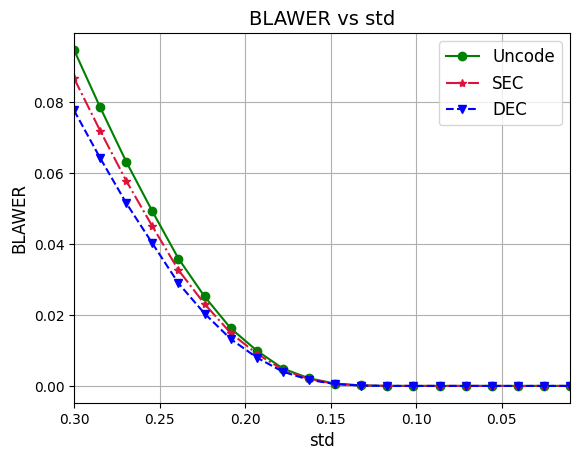

In [37]:
# 繪製結果
Uncode = plt.plot(std_values, blawer_values, marker='o', linestyle='-',color='#008000',label="Uncode")
SEC    = plt.plot(std_values, sec_blawer_values, marker='*', linestyle='-.',color='#DC143C',label="SEC")
DEC    = plt.plot(std_values, dec_blawer_values, marker='v', linestyle='--',color='#0000FF',label="DEC")

plt.xlim(Max_std, min_std)  # 讓 X 軸從 Max std 到 min std

# 增加標籤與圖例
plt.legend(fontsize=12, loc="upper right")
plt.xlabel('std', fontsize=12)
plt.ylabel('BLAWER', fontsize=12)
plt.title('BLAWER vs std', fontsize=14)
plt.grid(True)
plt.savefig("BLAWER_vs_std(3e-1~1e-2)")
plt.show()